A Neural Network is a machine learning model that learns to represent data in ways that make prediction or pattern recognition easier. It consists of layers of neurons, where each layer applies a linear transformation to its input followed by a non-linear activation function. Stacking these layers allows the network to approximate complex relationships in data.

Passing the input through this sequence of layers is called a forward pass — we compute predictions by applying the network function. To optimize the weights, we then perform backwards propagation, where we compute gradients of the loss with respect to each weight. Using the chain rule, each layer’s gradient depends on both its own transformation and the gradients from the layers that follow, allowing the network to update all weights in a way that reduces the overall loss.

Considering such, each function in this notebook is implemented as a class with modules for the forwards and backwards pass


### Feedforward Neural Network with Numpy

See below the two functions we will use in our hidden layers: standard Linear Regression and Rectified Linear Unit (ReLu). ReLu sets all values below 0 to 0. Without a non-linear element the network would be limited to prediciting linear patterns.  

In [2]:
import numpy as np

In [3]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim) # initialise weights at random
        self.biases = np.zeros((1, output_dim))
        self.input = None
        self.grad_weights = None
        self.grad_biases = None

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.biases # standard linear regression wc + b

    def backward(self, grad_output):
        # grad_output is gradient from previous layer
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

    def parameters(self):
        return [(self.weights, self.grad_weights), (self.biases, self.grad_biases)]

In [4]:
class ReLu:
    def __call__(self, x):
        self.input = x
        self.out = np.maximum(x, 0)
        return self.out

    def forward(self, z):
        return self(z)

    # If value is 0 gradient from previous step will be blocked ( * 0)
    def backward(self, gradient_output):
        return (self.input > 0) * gradient_output

    def parameters(self):
        return []

The below class  ais simple feedforward network. It works in the same way as if you used Pytorch's `nn.Sequential`, with layers (or the neural network) being provided as a list. It is limited to simple regression and classification tasks, failing at capturing spatial features like a convolutional network would do, or time series/sequences like a Recurrent Neural Network or Long Short Term Memonry (LSTM) network.

In [5]:
class NeuralNetwork:
    def __init__(self, layers = []):
        self.layers = layers

    # add layer
    def add_layer(self, layer):
        self.layers.append(layer)

    # pass data through each function
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    # backwards propagation through each function
    def backward(self, gradient_output):
        for layer in reversed(self.layers):
            gradient_output = layer.backward(gradient_output)
        return gradient_output

    # return parameters and gradients - used in optimisation
    def parameters_and_gradients(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [6]:
# for regression tasks the loss will be Mean Squared Error
def MSE(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

# needed for gradient descent
def MSE_grad(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.shape[0]

In Neural Networks we use Optimizers to update the models paramaters to a point where the loss is at a minimum. We do this commonly with gradient descent, however with Neural Networks standard gradient descent can be unstable due to the high number of gradients calculated and multiplied together, leading to them eventually vanishing.

The most common way to combat this is using Adam (Adaptive Moment Estimation). It improves over standard gradient descent by keeping a running average of past gradients (momentum) and their squared values (adaptive scaling). This allows it to converge faster and more stably: momentum helps avoid getting stuck in poor local minima, and adaptive learning rates ensure smaller steps in steep regions and larger, steady steps in flatter regions.

The ADAM equation is:

Mean of gradients = $m_t$ = $\beta_1 m_{t-1} + (1 - \beta_1) g_t$

Variance of gradients = $v_t$ = $\beta_2 v_{t-1} + (1 - \beta_2) g_t^2$

Bias correction = $\hat{m}$ = $\frac{m_t}{1 - \beta_1^t}$, $\hat{v}$ = $\frac{v_t}{1 - \beta_2^t}$

Parameter update = $w_t$ = $w_{t-1} - \alpha \cdot \frac{\hat{m}_t}{{\sqrt{\hat{v_t}}} - \epsilon}$

$g$ = gradient

$\beta_1, \beta_2$ = decay rates

$\alpha$ = learning rate

In [8]:
class AdamOpt:
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [np.zeros_like(p[0]) for p in params] # create array of zeros to initialise momentum
        self.v = [np.zeros_like(p[0]) for p in params] # create array of zeros to initialise variance
        self.t = 0 # time step

    def step(self):
        self.t += 1
        for i, (param, grad) in enumerate(self.params):
            if grad is None:
                continue
            # update mean
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            # update variance
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * np.square(grad)
            # correct bias
            m_hat = self.m[i] / (1 - np.power(self.beta1, self.t))
            v_hat = self.v[i] / (1 - np.power(self.beta2, self.t))
            # update
            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

Now it is time to use the functions above to train a Neural Network.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

house_data = fetch_california_housing()

X = house_data.data
y = house_data.target

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalise
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape y to match network output
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [28]:
# train network using functions implemented above
network = NeuralNetwork([
    Linear(8, 16),       # input 8 = number of features
    ReLu(),
    Linear(16, 1)

])

epochs = 1000

for epoch in range(epochs):
    y_pred = network.forward(X_train) # predict
    loss = MSE(y_train, y_pred)       # calculate loss
    grad_loss = MSE_grad(y_train, y_pred)  # calculate gradient of loss
    network.backward(grad_loss)       # back propagate
    AdamOpt(network.parameters_and_gradients(), lr=0.01).step() # optimise
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

Epoch 100/1000, Loss: 0.32861269443536995
Epoch 200/1000, Loss: 0.3121899088567627
Epoch 300/1000, Loss: 0.30287473924917446
Epoch 400/1000, Loss: 0.3022505610221429
Epoch 500/1000, Loss: 0.30191883642630374
Epoch 600/1000, Loss: 0.30191673521971046
Epoch 700/1000, Loss: 0.3019146316135095
Epoch 800/1000, Loss: 0.30191253420340514
Epoch 900/1000, Loss: 0.3019104398097453
Epoch 1000/1000, Loss: 0.3019083478403553


When weights have been learnt, test on unseen data.

In [29]:
y_pred_test = network.forward(X_test)
loss_test = MSE(y_test, y_pred_test)
print(f"Test Loss: {loss_test}")


Test Loss: 0.30423044411969097


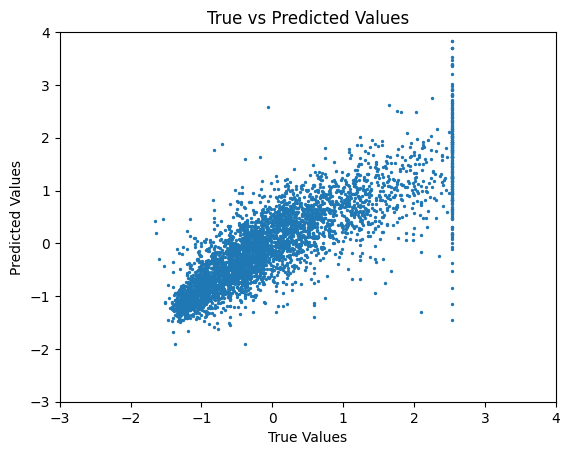

In [35]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_test, s=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.xlim(-3, 4)
plt.ylim(-3, 4)
plt.title("True vs Predicted Values")
plt.show()


The positive correlation shows the model predicted house prices well up until the most expensive. One could assume that an unaccounted attribute is causing all other attributes to be less affective for those houses.

This is a very simple Neural Network and would take some time to scale. For this reason we use libraries like PyTorch and TensorFlow. They automatically compute gradients, have premade layers and optimizers, and can run on GPUs. Below is an example of the above implementation but using PyTorch.

###Feedforward Neural Network with PyTorch

In [11]:
# Testing our problem using PyTorch
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

house_data = fetch_california_housing()

X = house_data.data
y = house_data.target

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalise
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [12]:
# make network. nn.Module provides PyTorch functionality
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # initialise parent class - nn.Module
        self.layers = nn.Sequential(
            nn.Linear(8,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
# train model
model = NeuralNetwork()
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 1000

for epoch in range(epochs):
    y_pred = model(X_train)
    loss_value = loss(y_pred, y_train)
    # backwards pass
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_value.item():.4f}")

Epoch 100/1000, Loss: 0.2923
Epoch 200/1000, Loss: 0.2575
Epoch 300/1000, Loss: 0.2416
Epoch 400/1000, Loss: 0.2324
Epoch 500/1000, Loss: 0.2274
Epoch 600/1000, Loss: 0.2243
Epoch 700/1000, Loss: 0.2224
Epoch 800/1000, Loss: 0.2198
Epoch 900/1000, Loss: 0.2183
Epoch 1000/1000, Loss: 0.2175


Test Loss: 0.2301


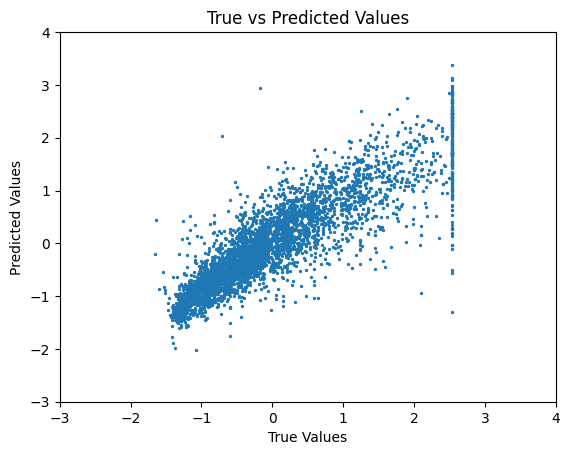

In [14]:
with torch.no_grad():
    y_pred_test = model(X_test)
    loss_test = loss(y_pred_test, y_test)
    print(f"Test Loss: {loss_test.item():.4f}")

plt.scatter(y_test, y_pred_test, s=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.xlim(-3, 4)
plt.ylim(-3, 4)
plt.title("True vs Predicted Values")
plt.show()